# Expedia Hotel Recommendations 
### *Which hotel type will an Expedia customer book?*

This is a data analysis to predict the likelihood a user stay at 100 different hotel groups. Kaggle competition link [here](https://www.kaggle.com/competitions/expedia-hotel-recommendations/overview).

##### **[Introduction]:**
Expedia provided lots of logs of customer search behavior. These includes what customers searched for, how they interacted with the results (i.e. click only or book), whether or not the search result was a travel package, etc. It indicate the behavior of a part of a random selected customers but not representive for the all groups.

As for the target, Expedia has in-house algorithms to form hotels as *hotel_cluster*, where similar hotels (in terms of customer searches) are grouped together. This helps to serve as a good identifier of a type of a hotel is for customers, while avoiding problems such as a cold start when a new hotel is added in our search list. 

Our task of the analysis is to predict the booking outcome (*hotel_cluster*) for user search events. Hotels are clustered into 100 different groups. 

##### **[Data]:** 
The train and test data sets are separated based on time: training data is from 2013 and 2014, and test data is all from 2015. Training data has logs both for click and book, while test only with the booking records.

##### **[Metric]:**
We can make up to 5 predictions for each user event. The performance of the prediction will be evaluated according to the Mean Average Precision ([MAP@5](#metric)).
A detailed explanation can be found [here](https://www.kaggle.com/code/debarshichanda/understanding-mean-average-precision/notebook).

## Analysis Content and Summary

##### **[[Data Understanding](#data_understanding)]:**
Understanding the size and the features of the datasets. We see all the hotel groups have ever been booked, and the data has around 8% of booking rate out of the whole logs. Besides, there's a 32% of users who only checked the hotels (click logs) but not making any booking. 

##### **[[Feature Engineering](#feature_engineering)]:**
Features are prepared, scaled, and one-hot converted if that're a categorical variables. NaN values are filled. Aggregation tables are prepared for the follow steps of modeling. Some distributions between train set and test set are compared. 

##### **[Define the Problem]:**
We tackle this analysis problem in 3 different approaches:

1. The first method doesn't need ML modelling, just count the top 5 most often booked *hotel_cluster* of each *srch_destination_id*. There is no personalized recommendation, and only the same predicting results are made for the destination. See: [baseline model](#baseline_model).

2. Another way is define this problem as one hundred classification problems. For each classification problem, we only predict the possibility that a specific *hotel_cluster* will be booked. Because we have 100 *hotel_cluster*, each user event has 100 classification probabilities corresponding to these 100 groups. The recommending results can be generated by taking the top 5 highest possibilties. See: [100 ML models](#100_ml_models).

3. The last method improves the previous, and only intends to make a classification model. We can duplicate the user event a hundred times with mark the reservation of this 100 *hotel_cluster* as yes or no in sequence. This can help outlines the relationship between hotel groups. For example, it allows us to introduce functions such as how often a *hotel_cluster* is booked, and we don't need to worry that it will bring data leakage when modelling. In our actual practice, we further aggregate the booking and clicking frequencies with *srch_destination_id* and *hotel_cluster*. It is like a two-dimensional matching and these features are of great help to the performance of the model. The final prediction is made by taking the top 5 highest possibilities of each user event. See: [aggregation table](#aggregation_table), [RandomForest](#single_ml_model_random), [LogisticRegression](#single_ml_model_logistic).

To be notice that regards to the probability in approaches 2 and 3, the probability sum of 100 *hotel_cluster* by a user event will not necessarily to equal to 1.  It could be all close to 0 when the features don't show enough discrimination in predicting which hotel group will be booked. Then the sum of 100 probabilities is far less than 1. It may also have several high probabilities that the sum will eventually be greater than 1. (See plots in: [probability sum](#probability_sum)) When we are modeling, we try to predict an absolute value of probability rather than a probability of relative comparison between groups. This is so called point-wise approach in ranking problems. The values of probabilities probably need to be calibrated and it is always a much more difficult task to predict the absolute values accurately.   

##### **[Modeling and Prediction Results]:**
* Approach 1: non-ML model and it has the ability to reach 0.305 on MAP@5. 

* Approach 2: *LogisticRegression* with L1 penalty C=0.95 and saga optimizer. saga converges faster because we have 100 classification to do. \
It doesn't show a very good performance. Only 0.64 MAP@5. One of the reasons may be that I haven't optimized every classifier, but the biggest reason is that this model haven't use features of search destination, which is the most influential variables as you already seen in approach 1. The next model will includes some features relate to destinations.  

* Approach 3: *LogisticRegression* with L2 penalty C=1 and lbfgs optimizer and *RandomForestClassifier* with max_depth=5 and min_samples_split=1e-2. \
No big difference is observed between logistic regression and random forest, one being reported 0.306 and one is 0.305 MAP@5. The most impactful features are *prob_book_cluster* and *prob_click_cluster* (no surprise). Actually, before applying ML, approach 1 has already able to reach 0.305 on MAP@5, other features added in this model only helps a little. The popularity of destinations really plays the key on predictions. 

This can definitely keep improving. More thoughts can see this [section](#for_next).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

### **[Data Understanding]**<a id='data_understanding'></a>

In [3]:
train.shape

(37670293, 24)

In [4]:
test.shape

(2528243, 22)

In [5]:
booking_rate = train[train['is_booking']==1].shape[0]/train.shape[0]

In [6]:
unique_hotels = train['hotel_cluster'].nunique()
everbook_hotels = train[train['is_booking']==1]['hotel_cluster'].nunique()
neverbook_hotels = train[train['is_booking']==0]['hotel_cluster'].nunique()

unique_users = train['user_id'].nunique()
user_book_interactions = train[train['is_booking']==1].shape[0]

In [7]:
booking_rate

0.07965674702875288

In [8]:
print(unique_hotels)
print(everbook_hotels)
print(neverbook_hotels)
print(unique_users)
print(user_book_interactions)

100
100
100
1198786
3000693


**Numbers showed:**
1. all hotel clusters in the dataset had been *booked*
2. all hotel clusters in the dataset had been *clicked*
3. ~8% of booking rate
4. ~3 bookings/user

**More questions:**

Q5. which hotel clusters are *clicked* more often? \
Q6. which hotel clusters are *booked* more often? \
Q7. which hotel clusters are the least *booked*? \
Q8. the fraction of 'super' users (if >10 bookings)? -> 4% \
Q9. the fraction of the users who clicked the hotels but never booked any? -> 32%

In [9]:
# Q5:
print(train['hotel_cluster'].value_counts().index[:5])

# Q6:
print(train[train['is_booking']==1]['hotel_cluster'].value_counts().index[:5])

# Q7:
print(train[train['is_booking']==1]['hotel_cluster'].value_counts().index[-5:])

Int64Index([91, 41, 48, 64, 65], dtype='int64')
Int64Index([91, 48, 42, 59, 28], dtype='int64')
Int64Index([92, 87, 53, 27, 74], dtype='int64')


In [10]:
# Q8:
booking = train.groupby('user_id')['is_booking'].sum().reset_index(name='count_booking')
booking[booking['count_booking'] > 10].shape[0] /booking.shape[0]

0.042397892534614186

In [11]:
# Q9: 
booking[booking['count_booking']==0].shape[0] /booking.shape[0]

0.32099223714658

### **[Feature Engineering]**<a id='feature_engineering'></a>

In the following studies, I am going to remove *clicked* logs from our sampling (only remain *booking*) because: 

1. We study on how to improve the book rate \
The model built with this approach may not be applicable to the users' behavior who never *booked* (the 32%). The model makes recommendation according to the probabilities that are more likely to be *booked*. 

2. This is an imblanced dataset with only 8% of booked logs \
This is a skewed dataset that the most are labeled as class 0 (click). We wish to build a model that has good performance on predicting the likelihood of hotels that should be booked rather than predicting whether it would be clicked or booked. So removing the click logs shouldn't hurt our modeling. We will still try to acquire some useful information from click logs and add it as a kind of feature into our modeling (See: [aggregration table](#aggregration_table)). 

#### Preparing time-related features 

In [12]:
# Feature: trip duration, search made how many days ahead before traveling 
train['date'] = pd.to_datetime(train['date_time']).dt.date
train['srch_ci'] = pd.to_datetime(train['srch_ci'], errors = 'coerce').dt.date
train['srch_co'] = pd.to_datetime(train['srch_co'], errors = 'coerce').dt.date
train['srch_weekday'] = pd.to_datetime(train['date_time']).dt.weekday

train['trip_duration'] = (train['srch_co'] - train['srch_ci']).dt.days
train['trip_ahead'] = (train['srch_ci'] - train['date']).dt.days
train['trip_month'] = pd.to_datetime(train['srch_ci']).dt.month
train['trip_weekday'] = pd.to_datetime(train['srch_ci']).dt.weekday

In [13]:
test['date'] = pd.to_datetime(test['date_time']).dt.date

In [14]:
train.loc[:, ['user_id','date','srch_weekday',
              'trip_duration','trip_ahead','trip_month','trip_weekday',
              'is_booking']].head(15)

,user_id,date,srch_weekday,trip_duration,trip_ahead,trip_month,trip_weekday,is_booking
0,12,2014-08-11,0,4.0,16.0,8.0,2.0,0
1,12,2014-08-11,0,4.0,18.0,8.0,4.0,1
2,12,2014-08-11,0,4.0,18.0,8.0,4.0,0
3,93,2014-08-09,5,5.0,106.0,11.0,6.0,0
4,93,2014-08-09,5,5.0,106.0,11.0,6.0,0
5,93,2014-08-09,5,5.0,106.0,11.0,6.0,0
6,501,2014-07-16,2,1.0,16.0,8.0,4.0,0
7,501,2014-07-16,2,1.0,16.0,8.0,4.0,0
8,501,2014-07-16,2,1.0,16.0,8.0,4.0,0
9,501,2014-07-16,2,1.0,16.0,8.0,4.0,0


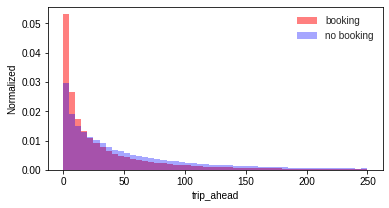

In [15]:
fig,ax = plt.subplots(figsize=(6,3))
plt.style.use('seaborn-whitegrid')
plt.grid(False)

plt.hist(train[train['is_booking']==1]["trip_ahead"], bins=50, range=[0, 250], density=1, alpha=0.5, color='r', label='booking')
plt.hist(train[train['is_booking']==0]["trip_ahead"], bins=50, range=[0, 250], density=1, alpha=0.35, color='b', label='no booking')
plt.legend()
ax.set_xlabel('trip_ahead')
ax.set_ylabel('Normalized');

#### Train & Test data split should be made on the data that is ordered by time 

In [16]:
train = train.sort_values('date')
test = test.sort_values('date')

In [19]:
train_set = train.loc[pd.to_datetime(train['date_time']).dt.year == 2013]
dev_set = train.loc[pd.to_datetime(train['date_time']).dt.year == 2014]

In [20]:
print(train.shape)

print(train_set.shape)
print(dev_set.shape)

(37670293, 30)
(11186881, 30)
(26483412, 30)


#### Aggrogration Tables (include them carefully to aviod data leakage)

#### [*df_hotel_cluster*]: groupby *hotel_cluster* and derive the corresponding numbers of *book* and *click* 

In [21]:
# Feature: booking rate, click rate
df_hotel_cluster = train_set.groupby('hotel_cluster') \
                    .agg(num_books=('is_booking','sum'),
                         num_clicks=('is_booking','size'),
                        ).reset_index()

# The fraction of booking in a specific cluster over all bookings for all clusters
df_hotel_cluster['booking_popularity'] = df_hotel_cluster['num_books']/df_hotel_cluster['num_books'].sum()

# The frequency of booking happened out of the clicks had in each of the clusters
df_hotel_cluster['books_outof_clicks'] = df_hotel_cluster['num_books']/df_hotel_cluster['num_clicks']

df_hotel_cluster

,hotel_cluster,num_books,num_clicks,booking_popularity,books_outof_clicks
0,0,6857,112780,0.006694,0.060800
1,1,15305,138263,0.014941,0.110695
2,2,15183,127063,0.014822,0.119492
3,3,5965,91712,0.005823,0.065041
4,4,11996,100790,0.011710,0.119020
...,...,...,...,...,...
95,95,20156,169308,0.019676,0.119049
96,96,6176,111982,0.006029,0.055152
97,97,9552,140917,0.009325,0.067785
98,98,15601,165423,0.015230,0.094310


In [22]:
df_hotel_cluster.to_csv('data/cluster_rates.csv', index=False)
df_hotel_cluster = pd.read_csv('data/cluster_rates.csv')

#### [*df_srch_destination_id*]: groupby *destination_id* and derive the corresponding numbers of *book* and *click*  

In [23]:
df_srch_destination_id = train_set.groupby(['srch_destination_id','hotel_cluster']).agg(
                                        num_books=('is_booking','sum'),
                                        num_clicks=('is_booking','size')).reset_index()

df_srch_destination_id = df_srch_destination_id.sort_values(by=['srch_destination_id','num_books','num_clicks'], ascending=(True,False,False))
df_srch_destination_id

,srch_destination_id,hotel_cluster,num_books,num_clicks
0,0,3,0,2
1,1,20,1,10
4,1,60,0,6
2,1,30,0,5
3,1,57,0,1
...,...,...,...,...
249335,62929,7,0,1
249338,62938,82,1,2
249339,62943,3,0,2
249340,62943,89,0,2


In [24]:
df_srch_destination_id['book_prob_in_a_srch_destination'] = df_srch_destination_id.groupby('srch_destination_id')['num_books'].apply(lambda x: x/x.sum())
df_srch_destination_id['click_prob_in_a_srch_destination'] = df_srch_destination_id.groupby('srch_destination_id')[['num_clicks']].apply(lambda x: x/x.sum())
df_srch_destination_id.fillna(0, inplace=True)
df_srch_destination_id

,srch_destination_id,hotel_cluster,num_books,num_clicks,book_prob_in_a_srch_destination,click_prob_in_a_srch_destination
0,0,3,0,2,0.0,1.000000
1,1,20,1,10,1.0,0.454545
4,1,60,0,6,0.0,0.272727
2,1,30,0,5,0.0,0.227273
3,1,57,0,1,0.0,0.045455
...,...,...,...,...,...,...
249335,62929,7,0,1,0.0,0.125000
249338,62938,82,1,2,1.0,1.000000
249339,62943,3,0,2,0.0,0.500000
249340,62943,89,0,2,0.0,0.500000


In [3]:
df_srch_destination_id.to_csv('data/destination_rates.csv', index=False)
df_srch_destination_id = pd.read_csv('data/destination_rates.csv')

#### [*df_2d*]: probabilities along with *srch_destination_id* and *hotel_cluster* <a id='aggregration_table'></a>

In [4]:
df_2d = pd.DataFrame(df_srch_destination_id.groupby('srch_destination_id')['hotel_cluster'].apply(list))
df_2d['prob_book'] = df_srch_destination_id.groupby('srch_destination_id')['book_prob_in_a_srch_destination'].apply(list)
df_2d['prob_click'] = df_srch_destination_id.groupby('srch_destination_id')['click_prob_in_a_srch_destination'].apply(list)
df_2d

,hotel_cluster,prob_book,prob_click
srch_destination_id,,,
0,[3],[0.0],[1.0]
1,"[20, 60, 30, 57]","[1.0, 0.0, 0.0, 0.0]","[0.4545454545454545, 0.2727272727272727, 0.227..."
2,"[20, 30]","[1.0, 0.0]","[0.6666666666666666, 0.3333333333333333]"
3,"[53, 60]","[0.0, 0.0]","[0.5, 0.5]"
4,"[32, 78, 81, 25, 30, 22, 43, 58, 38, 40, 67, 6...","[0.1791044776119403, 0.1194029850746268, 0.119...","[0.1233933161953727, 0.0874035989717223, 0.082..."
...,...,...,...
62927,"[28, 15, 16, 77, 91]","[0.0, 0.0, 0.0, 0.0, 0.0]","[0.4285714285714285, 0.1428571428571428, 0.142..."
62929,"[6, 28, 99, 5, 7]","[0.3333333333333333, 0.3333333333333333, 0.333...","[0.25, 0.25, 0.25, 0.125, 0.125]"
62938,[82],[1.0],[1.0]


In [5]:
def full_clusters(cluster, prob):
    out = np.zeros(100)
    n = len(cluster)
    for i in range(n):
        try:
            out[cluster[i]] = round(prob[i], 4)
        except IndexError:
            continue
        except TypeError:
            continue
    return out   

df_2d['prob_book_clusters'] = df_2d.apply(lambda x: full_clusters(x['hotel_cluster'],x['prob_book']),axis=1)
df_2d['prob_click_clusters'] = df_2d.apply(lambda x: full_clusters(x['hotel_cluster'],x['prob_click']),axis=1)
df_2d = df_2d.reset_index()
df_2d

,srch_destination_id,hotel_cluster,prob_book,prob_click,prob_book_clusters,prob_click_clusters
0,0,[3],[0.0],[1.0],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,1,"[20, 60, 30, 57]","[1.0, 0.0, 0.0, 0.0]","[0.4545454545454545, 0.2727272727272727, 0.227...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,2,"[20, 30]","[1.0, 0.0]","[0.6666666666666666, 0.3333333333333333]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,3,"[53, 60]","[0.0, 0.0]","[0.5, 0.5]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,4,"[32, 78, 81, 25, 30, 22, 43, 58, 38, 40, 67, 6...","[0.1791044776119403, 0.1194029850746268, 0.119...","[0.1233933161953727, 0.0874035989717223, 0.082...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...
40879,62927,"[28, 15, 16, 77, 91]","[0.0, 0.0, 0.0, 0.0, 0.0]","[0.4285714285714285, 0.1428571428571428, 0.142...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
40880,62929,"[6, 28, 99, 5, 7]","[0.3333333333333333, 0.3333333333333333, 0.333...","[0.25, 0.25, 0.25, 0.125, 0.125]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3333, 0.0, 0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.125, 0.25, 0.125, ..."
40881,62938,[82],[1.0],[1.0],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
40882,62943,"[3, 89]","[0.0, 0.0]","[0.5, 0.5]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


#### Dump the outputs inot lists for later use: 
[*dict_destination*]: at most 5 hotel clusters returned for each destination_id \
[*dict_prob_book*]: the corresponding list with booking probabilities \
[*dict_prob_click*]:  the corresponding list with click probabilities

In [43]:
dict_cluster = df_srch_destination_id.groupby('srch_destination_id')['hotel_cluster'].apply(list).to_dict()
dict_book_prob = df_srch_destination_id.groupby('srch_destination_id')['book_prob_in_a_srch_destination'].apply(list).to_dict()
dict_click_prob = df_srch_destination_id.groupby('srch_destination_id')['click_prob_in_a_srch_destination'].apply(list).to_dict()

In [44]:
dict_destination = {}
for destination, cluster in dict_cluster.items():
    top5 = len(cluster) if len(cluster)<5 else 5
    dict_destination[destination] = cluster[:top5]

#dict_destination

In [45]:
dict_prob_book = {}
for destination, prob in dict_book_prob.items():
    top5 = len(prob) if len(prob)<5 else 5
    dict_prob_book[destination] = [round(i, 2) for i in prob[:top5]]
      
#dict_prob_book

In [46]:
dict_prob_click = {}
for destination, prob in dict_click_prob.items():
    top5 = len(prob) if len(prob)<5 else 5
    dict_prob_click[destination] = [round(i, 2) for i in prob[:top5]]
    
#dict_prob_click

#### dump into dataframes and save as csv files

In [47]:
df_destination_clusters = pd.DataFrame.from_dict(dict_destination, orient='index', columns=['cluster1','cluster2','cluster3','cluster4','cluster5'])
df_destination_clusters.to_csv('data/destination_clusters.csv', index=True)
df_destination_clusters = pd.read_csv('data/destination_clusters.csv')

df_destination_book_probs = pd.DataFrame.from_dict(dict_prob_book, orient='index', columns=['prob1','prob2','prob3','prob4','prob5'])
df_destination_book_probs.to_csv('data/destination_book_probs.csv', index=True)
df_destination_book_probs = pd.read_csv('data/destination_book_probs.csv')

df_destination_click_probs = pd.DataFrame.from_dict(dict_prob_click, orient='index', columns=['prob1','prob2','prob3','prob4','prob5'])
df_destination_click_probs.to_csv('data/destination_click_probs.csv', index=True)
df_destination_click_probs = pd.read_csv('data/destination_click_probs.csv')

#### Features Summary:
*Y^* is hotel clusters, given *X* are the properities of searching conditions
- Search conditions: Variables for ML model built-up
  * trip duration
  * trip planed in which month/weekday 
  * search made days before traveling 
  * number of adults/children/rooms 
  * weekday of the search made 
  * distance of the destination from home 
  * destination id/type_id 
  * hotel in which country/continent
  * divice on mobile or others
  * sold in package or not
  * marketing channel 
  

- hotel cluster & serch_destination_id properties: Variables for returning non-ML results. Use it carefully in case of data leakage.
  * book rate out of all categories
  * click rate out of all categories
  * book times out of clicks in itself category
  

In [35]:
train_set.columns

Index(['date_time', 'site_name', 'posa_continent', 'user_location_country',
       'user_location_region', 'user_location_city',
       'orig_destination_distance', 'user_id', 'is_mobile', 'is_package',
       'channel', 'srch_ci', 'srch_co', 'srch_adults_cnt', 'srch_children_cnt',
       'srch_rm_cnt', 'srch_destination_id', 'srch_destination_type_id',
       'is_booking', 'cnt', 'hotel_continent', 'hotel_country', 'hotel_market',
       'hotel_cluster', 'date', 'srch_weekday', 'trip_duration', 'trip_ahead',
       'trip_month', 'trip_weekday'],
      dtype='object')

In [36]:
train_set = train_set.loc[(train_set['is_booking']==1)]
dev_set = dev_set.loc[(dev_set['is_booking']==1)]

In [37]:
print(train_set.shape)
print(dev_set.shape)

(1024389, 30)
(1976304, 30)


In [38]:
train_set.isna().sum()

date_time                         0
site_name                         0
posa_continent                    0
user_location_country             0
user_location_region              0
user_location_city                0
orig_destination_distance    349511
user_id                           0
is_mobile                         0
is_package                        0
channel                           0
srch_ci                           0
srch_co                           0
srch_adults_cnt                   0
srch_children_cnt                 0
srch_rm_cnt                       0
srch_destination_id               0
srch_destination_type_id          0
is_booking                        0
cnt                               0
hotel_continent                   0
hotel_country                     0
hotel_market                      0
hotel_cluster                     0
date                              0
srch_weekday                      0
trip_duration                     0
trip_ahead                  

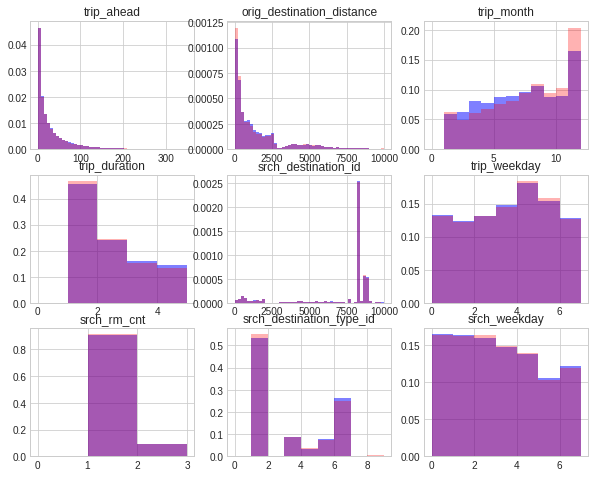

In [39]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 8))

ax=axes[0,0]
ax.hist(train_set['trip_ahead'], bins=50, range=[0,350], density=1, alpha=0.5, color='b', label='2013')
ax.hist(dev_set['trip_ahead'], bins=50, range=[0,350], density=1, alpha=0.3, color='r', label='2014')
ax.set_title('trip_ahead');

ax=axes[1,0]
ax.hist(train_set['trip_duration'], bins=5, range=[0,5], density=1, alpha=0.5, color='b', label='2013')
ax.hist(dev_set['trip_duration'], bins=5, range=[0,5], density=1, alpha=0.3, color='r', label='2014')
ax.set_title('trip_duration');

ax=axes[2,0]
ax.hist(train_set['srch_rm_cnt'], bins=3, range=[0,3], density=1, alpha=0.5, color='b', label='2013')
ax.hist(dev_set['srch_rm_cnt'], bins=3, range=[0,3], density=1, alpha=0.3, color='r', label='2014')
ax.set_title('srch_rm_cnt');

ax=axes[0,1]
ax.hist(train_set['orig_destination_distance'], bins=50, range=[0,10000], density=1, alpha=0.5, color='b', label='2013')
ax.hist(dev_set['orig_destination_distance'], bins=50, range=[0,10000], density=1, alpha=0.3, color='r', label='2014')
ax.set_title('orig_destination_distance');

ax=axes[1,1]
ax.hist(train_set['srch_destination_id'], bins=50, range=[0,10000], density=1, alpha=0.5, color='b', label='2013')
ax.hist(dev_set['srch_destination_id'], bins=50, range=[0,10000], density=1, alpha=0.3, color='r', label='2014')
ax.set_title('srch_destination_id');

ax=axes[2,1]
ax.hist(train_set['srch_destination_type_id'], bins=9, range=[0,9], density=1, alpha=0.5, color='b', label='2013')
ax.hist(dev_set['srch_destination_type_id'], bins=9, range=[0,9], density=1, alpha=0.3, color='r', label='2014')
ax.set_title('srch_destination_type_id');

ax=axes[0,2]
ax.hist(train_set['trip_month'], bins=12, range=[0,12], density=1, alpha=0.5, color='b', label='2013')
ax.hist(dev_set['trip_month'], bins=12, range=[0,12], density=1, alpha=0.3, color='r', label='2014')
ax.set_title('trip_month');

ax=axes[1,2]
ax.hist(train_set['trip_weekday'], bins=7, range=[0,7], density=1, alpha=0.5, color='b', label='2013')
ax.hist(dev_set['trip_weekday'], bins=7, range=[0,7], density=1, alpha=0.3, color='r', label='2014')
ax.set_title('trip_weekday');

ax=axes[2,2]
ax.hist(train_set['srch_weekday'], bins=7, range=[0,7], density=1, alpha=0.5, color='b', label='2013')
ax.hist(dev_set['srch_weekday'], bins=7, range=[0,7], density=1, alpha=0.3, color='r', label='2014')
ax.set_title('srch_weekday');

In [40]:
train_set.groupby('srch_destination_type_id')['orig_destination_distance'].mean()

srch_destination_type_id
0            NaN
1    1777.272526
3    1504.342680
4    1134.002485
5    1938.631123
6    1653.653711
8    1831.813781
Name: orig_destination_distance, dtype: float64

In [41]:
train_set.groupby('srch_destination_type_id')['orig_destination_distance'].std()

srch_destination_type_id
0            NaN
1    2147.358058
3    2064.547505
4    1748.426079
5    2230.075177
6    2129.443540
8    2002.809721
Name: orig_destination_distance, dtype: float64

Replace the nan by the mean because that seems doesn't show to follow a specific pattern given the statistics

In [42]:
values = {'orig_destination_distance':train_set['orig_destination_distance'].mean()}
train_set.fillna(values, inplace=True)

values = {'orig_destination_distance':dev_set['orig_destination_distance'].mean()}
dev_set.fillna(values, inplace=True)

In [43]:
train_set.isna().sum()

date_time                    0
site_name                    0
posa_continent               0
user_location_country        0
user_location_region         0
user_location_city           0
orig_destination_distance    0
user_id                      0
is_mobile                    0
is_package                   0
channel                      0
srch_ci                      0
srch_co                      0
srch_adults_cnt              0
srch_children_cnt            0
srch_rm_cnt                  0
srch_destination_id          0
srch_destination_type_id     0
is_booking                   0
cnt                          0
hotel_continent              0
hotel_country                0
hotel_market                 0
hotel_cluster                0
date                         0
srch_weekday                 0
trip_duration                0
trip_ahead                   0
trip_month                   0
trip_weekday                 0
dtype: int64

In [44]:
dev_set.isna().sum()

date_time                    0
site_name                    0
posa_continent               0
user_location_country        0
user_location_region         0
user_location_city           0
orig_destination_distance    0
user_id                      0
is_mobile                    0
is_package                   0
channel                      0
srch_ci                      0
srch_co                      0
srch_adults_cnt              0
srch_children_cnt            0
srch_rm_cnt                  0
srch_destination_id          0
srch_destination_type_id     0
is_booking                   0
cnt                          0
hotel_continent              0
hotel_country                0
hotel_market                 0
hotel_cluster                0
date                         0
srch_weekday                 0
trip_duration                0
trip_ahead                   0
trip_month                   0
trip_weekday                 0
dtype: int64

In [45]:
feature2use = [
    'srch_weekday','trip_duration','trip_ahead','trip_month','trip_weekday',
    'srch_adults_cnt','srch_children_cnt','srch_rm_cnt','cnt',
    'srch_destination_id','srch_destination_type_id','hotel_continent',
    'orig_destination_distance','is_mobile','is_package','channel',
    'hotel_cluster'
    ]

In [44]:
train_set[feature2use].to_csv('data/train_booking.csv', index=False)
dev_set[feature2use].to_csv('data/dev_booking.csv', index=False)

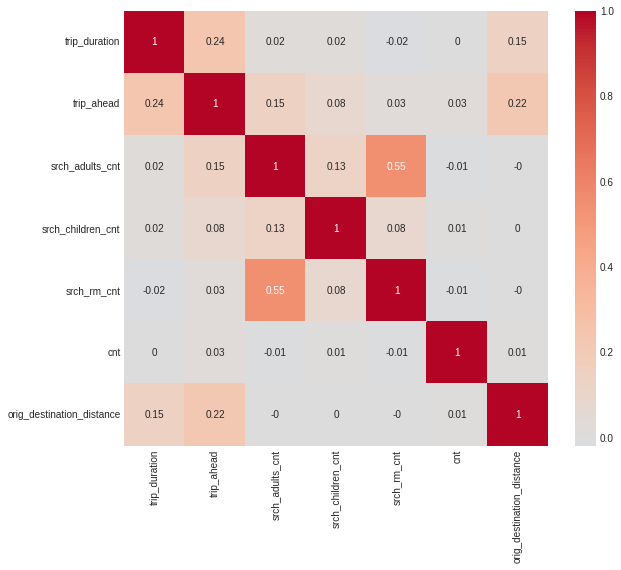

In [47]:
# only numerical variables are meaningful in a corr matrix
numerical_vars = [
    'trip_duration','trip_ahead',
    'srch_adults_cnt','srch_children_cnt','srch_rm_cnt','cnt',
    'orig_destination_distance']

corr = df_train[numerical_vars].corr().round(2)

fig, ax = plt.subplots(figsize=(9.5, 8))
sns.heatmap(data=corr, annot=True, cmap="coolwarm", robust=True, center=0);

### Metric<a id='metric'></a>

In [32]:
def apk(actual, predicted, k=10):
    """
    Computes the average precision at k.
    This function computes the average prescision at k between two lists of
    items.
    Parameters
    ----------
    actual : list
             A list of elements that are to be predicted (order doesn't matter)
    predicted : list
                A list of predicted elements (order does matter)
    k : int, optional
        The maximum number of predicted elements
    Returns
    -------
    score : double
            The average precision at k over the input lists
    """
    if len(predicted)>k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    for i,p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)

    if not actual:
        return 0.0

    return score / min(len(actual), k)

def mapk(actual, predicted, k=10):
    """
    Computes the mean average precision at k.
    This function computes the mean average prescision at k between two lists
    of lists of items.
    Parameters
    ----------
    actual : list
             A list of lists of elements that are to be predicted 
             (order doesn't matter in the lists)
    predicted : list
                A list of lists of predicted elements
                (order matters in the lists)
    k : int, optional
        The maximum number of predicted elements
    Returns
    -------
    score : double
            The mean average precision at k over the input lists
    """
    return np.mean([apk(a,p,k) for a,p in zip(actual, predicted)])


### [Baseline Model (non-ML)]: returning the most popular hotel clusters for the search destinatioin <a id='baseline_model'></a>

In [48]:
# Baseline without ML application, depends only on the destination id

actual = [[ele] for ele in df_dev['hotel_cluster'].tolist()]
predicted = []

for destination in df_dev['srch_destination_id'].tolist():
    try:
        predicted.append(dict_destination[destination])
    except KeyError:
        predicted.append([])
    
mapk(actual, predicted, k=5)

0.30499514076107037

In [12]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from itertools import chain

### [100 ML Models]: 100 binray classifications with Logistic Regressor <a id='100_ml_models'></a>

In [4]:
df_train = pd.read_csv('data/train_booking.csv')
df_dev = pd.read_csv('data/dev_booking.csv')

#### One-hot encoding for categorical variables

In [5]:
def encode_and_bind(original_dataframe, feature_to_encode, prefix):
    dummies = pd.get_dummies(original_dataframe[feature_to_encode], prefix=prefix)
    res = pd.concat([original_dataframe, dummies], axis=1)
    res = res.drop(feature_to_encode, axis=1)
    return(res) 

features_to_encode = ['srch_weekday','trip_weekday','trip_month',
                      'hotel_continent','channel']

for feature in features_to_encode:
    df_train = encode_and_bind(df_train, feature, feature)
    df_dev = encode_and_bind(df_dev, feature, feature)

In [6]:
df_train.columns

Index(['trip_duration', 'trip_ahead', 'srch_adults_cnt', 'srch_children_cnt',
       'srch_rm_cnt', 'cnt', 'srch_destination_id', 'srch_destination_type_id',
       'orig_destination_distance', 'is_mobile', 'is_package', 'hotel_cluster',
       'srch_weekday_0', 'srch_weekday_1', 'srch_weekday_2', 'srch_weekday_3',
       'srch_weekday_4', 'srch_weekday_5', 'srch_weekday_6',
       'trip_weekday_0.0', 'trip_weekday_1.0', 'trip_weekday_2.0',
       'trip_weekday_3.0', 'trip_weekday_4.0', 'trip_weekday_5.0',
       'trip_weekday_6.0', 'trip_month_1.0', 'trip_month_2.0',
       'trip_month_3.0', 'trip_month_4.0', 'trip_month_5.0', 'trip_month_6.0',
       'trip_month_7.0', 'trip_month_8.0', 'trip_month_9.0', 'trip_month_10.0',
       'trip_month_11.0', 'trip_month_12.0', 'hotel_continent_0',
       'hotel_continent_1', 'hotel_continent_2', 'hotel_continent_3',
       'hotel_continent_4', 'hotel_continent_5', 'hotel_continent_6',
       'channel_0', 'channel_1', 'channel_2', 'channel_3', '

In [7]:
print(len(df_train.columns.tolist()))
print(len(df_dev.columns.tolist()))

56
56


#### Feature transformers

In [8]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

scaler = MinMaxScaler()
vars_minmax = ['srch_adults_cnt','srch_children_cnt','srch_rm_cnt','cnt','trip_duration','trip_ahead','orig_destination_distance']

df_train_minmax = pd.DataFrame(scaler.fit_transform(df_train[vars_minmax]), columns=[vars_minmax])
df_dev_minmax = pd.DataFrame(scaler.fit_transform(df_dev[vars_minmax]), columns=[vars_minmax])

In [9]:
df_train.drop(columns=vars_minmax, axis=1)
df_dev.drop(columns=vars_minmax, axis=1)

df_train[vars_minmax] = df_train_minmax
df_dev[vars_minmax] = df_dev_minmax

#### for each of the search conditions, derive the probabilities for 100 of hotel cluters

In [10]:
unique_clusters = df_train['hotel_cluster'].unique()
unique_clusters.sort()

all_probs = []
for cluster in unique_clusters:
    df_train['target'] = np.where(df_train['hotel_cluster']==cluster, 1, 0)
    predictors = [col for col in df_train if col not in ['hotel_cluster','target',
                                                         'srch_destination_id','srch_destination_type_id']]
    
    clf = LogisticRegression(penalty='l1', solver='saga', C=0.95, max_iter=350, tol=1e-3, n_jobs=-1, random_state=0)
    clf.fit(df_train[predictors], df_train['target'])   
    
    prob = clf.predict_proba(df_dev[predictors])[:, 1]
    all_probs.append(prob)

In [11]:
prob_table = pd.DataFrame()

for i in range(unique_clusters.size):
    prob_table[unique_clusters[i]] = all_probs[i]

prob_table.to_csv('data/model1/prob_table.csv', index=False)
prob_table

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.043599,0.380285,0.004862,0.002113,0.003316,0.006572,0.002728,0.000939,0.002838,0.028713,...,0.009351,0.011194,0.009456,0.002273,0.005388,0.019062,0.026067,0.011799,0.043654,0.006178
1,0.038310,0.071217,0.004177,0.003434,0.003395,0.007478,0.004402,0.003554,0.007356,0.020099,...,0.024422,0.032484,0.009029,0.005700,0.008950,0.014279,0.036988,0.011091,0.035343,0.005230
2,0.015434,0.143774,0.004389,0.003395,0.004164,0.007503,0.005324,0.005343,0.004658,0.025267,...,0.017694,0.024502,0.005316,0.005986,0.008031,0.013956,0.018596,0.006929,0.022044,0.006108
3,0.000390,0.000009,0.009899,0.016530,0.000330,0.021192,0.004944,0.001316,0.054731,0.032131,...,0.012253,0.000512,0.011323,0.002794,0.000524,0.002464,0.007452,0.023969,0.005345,0.023417
4,0.016094,0.134986,0.004178,0.005282,0.004547,0.007819,0.004869,0.004437,0.006229,0.029320,...,0.022482,0.022043,0.005536,0.008219,0.007517,0.011316,0.020632,0.007291,0.024173,0.006907
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1976299,0.018731,0.091087,0.004407,0.004278,0.004056,0.007726,0.003947,0.003976,0.005783,0.031024,...,0.023030,0.023781,0.006797,0.009283,0.007132,0.014855,0.018377,0.008362,0.036509,0.007269
1976300,0.000008,0.000009,0.020688,0.010842,0.000323,0.031342,0.003964,0.001795,0.030457,0.028031,...,0.026773,0.000940,0.000787,0.014663,0.000502,0.003662,0.000068,0.013196,0.014807,0.021633
1976301,0.014514,0.058063,0.004755,0.003231,0.004173,0.008734,0.006019,0.004883,0.003445,0.022706,...,0.012053,0.025793,0.002766,0.005107,0.009382,0.017832,0.014584,0.007048,0.025147,0.006235
1976302,0.035859,0.326091,0.004758,0.001973,0.003447,0.006683,0.003306,0.001334,0.002974,0.027643,...,0.009564,0.011235,0.009010,0.002450,0.005467,0.019136,0.022795,0.009264,0.039331,0.006654


In [12]:
pred_table = pd.DataFrame(
                prob_table.apply(lambda x: list(prob_table.columns[np.array(x).argsort()[::-1][:5]]), axis=1).to_list(),  
                columns=['pred_1','pred_2','pred_3','pred_4','pred_5'])

pred_table['ans'] = df_dev['hotel_cluster'].tolist()
pred_table

,pred_1,pred_2,pred_3,pred_4,pred_5,ans
0,1,45,79,88,71,17
1,71,1,73,41,55,91
2,1,79,71,54,55,54
3,63,8,12,62,85,36
4,1,55,79,41,71,90
...,...,...,...,...,...,...
1976299,1,41,55,71,73,7
1976300,62,22,30,64,5,20
1976301,1,41,55,79,54,51
1976302,1,79,45,71,88,91


In [13]:
actual = [[ele] for ele in pred_table['ans'].tolist()]
predicted = [row[:5] for row in pred_table.values.tolist()]

mapk(actual, predicted, k=5)

0.06407017004131615

##### This is just an example for the last classification model (hotel_cluster=99)

In [14]:
clf.coef_[0]

array([-1.15224868e+00,  1.47654779e-01, -4.73317330e-02, -1.00120861e+00,
        1.38229393e-01, -4.74956753e-01,  1.80797176e-01,  5.30922468e-02,
       -7.49294687e-03, -2.17768873e-02,  1.17611627e-02,  1.82236220e-02,
        4.74658747e-03, -4.32671405e-02, -3.21873230e-02,  0.00000000e+00,
        1.81704701e-02,  0.00000000e+00,  2.55802466e-02, -6.50810505e-03,
       -3.18511580e-02, -3.48260640e-02,  1.55826183e-03, -5.11718809e-02,
        0.00000000e+00, -3.79884867e-02,  1.97193255e-02,  1.20771700e-01,
        1.30345833e-01,  0.00000000e+00,  2.63344328e-02, -9.28630934e-02,
        1.78329619e-02, -3.68757324e-02, -6.95261435e-02,  4.36698759e-01,
        0.00000000e+00, -1.16034537e+00,  2.04904164e-01, -7.65961354e-01,
       -1.77532219e+00,  6.27995644e-02,  8.33746578e-02,  7.03428248e-02,
        6.67057531e-02, -1.88330807e-02, -4.68568748e-02,  6.47838716e-02,
       -1.83680451e-01,  1.27022073e-01, -2.44497628e-01,  0.00000000e+00,
       -1.51860281e-01])

/scratch/local/27494692/ipykernel_63439/1680786193.py:7: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout()


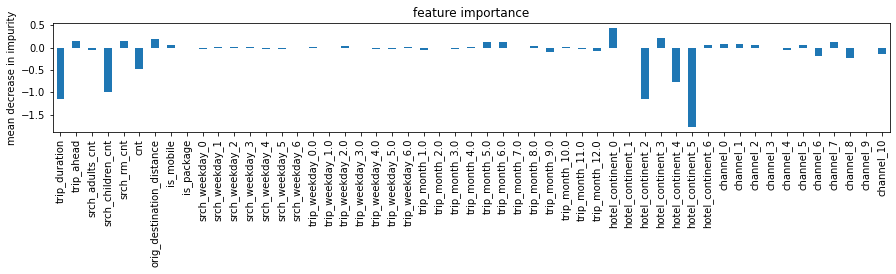

In [15]:
importances = pd.Series(data=clf.coef_[0], index=predictors)

fig, ax = plt.subplots(figsize=(15, 2))
importances.plot.bar(ax=ax)
ax.set_title("feature importance")
ax.set_ylabel("mean decrease in impurity")
fig.tight_layout()

Many of the categorical features are not that impactful or it shirks to zero with L1 regularization. I will leave them out of the model features in the following modeling.

### [single ML Model]: 1 classifications with Random Forest <a id='single_ml_model_random'></a>

In [14]:
df_train = pd.read_csv('data/train_booking.csv')
df_dev = pd.read_csv('data/dev_booking.csv')

In [15]:
features_to_encode = ['trip_month','channel']

for feature in features_to_encode:
    df_train = encode_and_bind(df_train, feature, feature)
    df_dev = encode_and_bind(df_dev, feature, feature)

In [16]:
def explode_is_booking(hotel_cluster):
    target = np.zeros(100, dtype=int)
    target[int(hotel_cluster)] = 1
    return target


df_train['is_booking'] = df_train.apply(lambda x: explode_is_booking(x['hotel_cluster']),axis=1)
df_dev['is_booking'] = df_dev.apply(lambda x: explode_is_booking(x['hotel_cluster']),axis=1)
df_train['cluster'] = df_train.apply(lambda x: np.arange(100),axis=1)
df_dev['cluster'] = df_dev.apply(lambda x: np.arange(100),axis=1)


predictors = ['trip_duration','trip_ahead','orig_destination_distance','srch_adults_cnt','srch_children_cnt','srch_rm_cnt','cnt',
              'is_mobile', 'trip_month_1.0', 'trip_month_2.0',
              'trip_month_3.0', 'trip_month_4.0', 'trip_month_5.0', 'trip_month_6.0',
              'trip_month_7.0', 'trip_month_8.0', 'trip_month_9.0', 'trip_month_10.0',
              'trip_month_11.0', 'trip_month_12.0',
              'srch_destination_id', 'cluster','is_booking']


df_train_model2 = pd.merge(df_train[predictors], df_2d[['srch_destination_id','prob_book_clusters','prob_click_clusters']], 
                           how='left', on=['srch_destination_id'])
df_dev_model2 = pd.merge(df_dev[predictors], df_2d[['srch_destination_id','prob_book_clusters','prob_click_clusters']], 
                         how='left', on=['srch_destination_id'])

In [17]:
df_train_model2.head()

,trip_duration,trip_ahead,orig_destination_distance,srch_adults_cnt,srch_children_cnt,srch_rm_cnt,cnt,is_mobile,trip_month_1.0,trip_month_2.0,...,trip_month_8.0,trip_month_9.0,trip_month_10.0,trip_month_11.0,trip_month_12.0,srch_destination_id,cluster,is_booking,prob_book_clusters,prob_click_clusters
0,1.0,20.0,5286.088000,1,0,1,1,0,1,0,...,0,0,0,0,0,12643,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0127, 0.0, 0.0, 0.019, 0.0, 0.006...","[0.0, 0.0, 0.0158, 0.0041, 0.0, 0.0397, 0.0, 0..."
1,1.0,2.0,1566.370400,2,0,2,1,0,1,0,...,0,0,0,0,0,12007,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,2.0,19.0,1708.045669,2,0,1,1,0,1,0,...,0,0,0,0,0,12233,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0304, 0.0063, 0.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.0342, 0.0063, 0.0, 0.0,..."
3,1.0,81.0,1708.045669,2,2,1,1,0,0,0,...,0,0,0,0,0,8864,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.025...","[0.0, 0.0, 0.0, 0.0021, 0.0, 0.0, 0.0, 0.0, 0...."
4,3.0,28.0,1708.045669,2,0,1,1,0,0,1,...,0,0,0,0,0,12250,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.216, 0.0, 0.0, 0.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.2279, 0.0, 0.0, 0...."


In [18]:
df_dev_model2.isna().sum()

trip_duration                    0
trip_ahead                       0
orig_destination_distance        0
srch_adults_cnt                  0
srch_children_cnt                0
srch_rm_cnt                      0
cnt                              0
is_mobile                        0
trip_month_1.0                   0
trip_month_2.0                   0
trip_month_3.0                   0
trip_month_4.0                   0
trip_month_5.0                   0
trip_month_6.0                   0
trip_month_7.0                   0
trip_month_8.0                   0
trip_month_9.0                   0
trip_month_10.0                  0
trip_month_11.0                  0
trip_month_12.0                  0
srch_destination_id              0
cluster                          0
is_booking                       0
prob_book_clusters           14694
prob_click_clusters          14694
dtype: int64

In [19]:
df_dev_model2['prob_book_clusters'] = df_dev_model2['prob_book_clusters'].apply(lambda x: x if type(x) is not float else [0.]*100)
df_dev_model2['prob_click_clusters'] = df_dev_model2['prob_click_clusters'].apply(lambda x: x if type(x) is not float else [0.]*100)

In [20]:
df_dev_model2.isna().sum()

trip_duration                0
trip_ahead                   0
orig_destination_distance    0
srch_adults_cnt              0
srch_children_cnt            0
srch_rm_cnt                  0
cnt                          0
is_mobile                    0
trip_month_1.0               0
trip_month_2.0               0
trip_month_3.0               0
trip_month_4.0               0
trip_month_5.0               0
trip_month_6.0               0
trip_month_7.0               0
trip_month_8.0               0
trip_month_9.0               0
trip_month_10.0              0
trip_month_11.0              0
trip_month_12.0              0
srch_destination_id          0
cluster                      0
is_booking                   0
prob_book_clusters           0
prob_click_clusters          0
dtype: int64

#### Data aggregration: the 2D matching

In [21]:
df_train_model2_explode = df_train_model2.explode(['is_booking','cluster','prob_book_clusters','prob_click_clusters'])
df_dev_model2_explode = df_dev_model2.explode(['is_booking','cluster','prob_book_clusters','prob_click_clusters'])

df_train_model2_explode.reset_index(inplace=True)
df_dev_model2_explode.reset_index(inplace=True)

In [22]:
df_dev_model2_explode

,index,trip_duration,trip_ahead,orig_destination_distance,srch_adults_cnt,srch_children_cnt,srch_rm_cnt,cnt,is_mobile,trip_month_1.0,...,trip_month_8.0,trip_month_9.0,trip_month_10.0,trip_month_11.0,trip_month_12.0,srch_destination_id,cluster,is_booking,prob_book_clusters,prob_click_clusters
0,0,7.0,12.0,2450.2304,1,0,1,1,0,1,...,0,0,0,0,0,8254,0,0,0.0,0.0
1,0,7.0,12.0,2450.2304,1,0,1,1,0,1,...,0,0,0,0,0,8254,1,0,0.0,0.0
2,0,7.0,12.0,2450.2304,1,0,1,1,0,1,...,0,0,0,0,0,8254,2,0,0.0113,0.0066
3,0,7.0,12.0,2450.2304,1,0,1,1,0,1,...,0,0,0,0,0,8254,3,0,0.0006,0.0016
4,0,7.0,12.0,2450.2304,1,0,1,1,0,1,...,0,0,0,0,0,8254,4,0,0.0455,0.0326
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197630395,1976303,5.0,46.0,1489.5095,2,0,1,1,0,0,...,0,0,0,0,0,8825,95,0,0.0,0.0
197630396,1976303,5.0,46.0,1489.5095,2,0,1,1,0,0,...,0,0,0,0,0,8825,96,0,0.034,0.0296
197630397,1976303,5.0,46.0,1489.5095,2,0,1,1,0,0,...,0,0,0,0,0,8825,97,0,0.0,0.0
197630398,1976303,5.0,46.0,1489.5095,2,0,1,1,0,0,...,0,0,0,0,0,8825,98,0,0.0,0.0


In [23]:
feature2fit_X = ['trip_duration','trip_ahead','orig_destination_distance','srch_adults_cnt','srch_children_cnt','srch_rm_cnt','cnt', 
                 'is_mobile', 'trip_month_1.0', 'trip_month_2.0',
                 'trip_month_3.0', 'trip_month_4.0', 'trip_month_5.0', 'trip_month_6.0',
                 'trip_month_7.0', 'trip_month_8.0', 'trip_month_9.0', 'trip_month_10.0',
                 'trip_month_11.0', 'trip_month_12.0',
                 'prob_book_clusters','prob_click_clusters']

In [24]:
clf = RandomForestClassifier(n_estimators=100, max_features="sqrt", min_samples_split=1e-2, max_depth=5, n_jobs=-1, random_state=0) 
clf.fit(df_train_model2_explode[feature2fit_X], df_train_model2_explode['is_booking'].astype('int'))   
prob = clf.predict_proba(df_dev_model2_explode[feature2fit_X])[:, 1]

In [25]:
from joblib import dump, load
dump(clf, 'data/model2.joblib')

['data/model2.joblib']

In [26]:
prob_table = pd.DataFrame({
    'index': df_dev_model2_explode['index'],
    'cluster':df_dev_model2_explode['cluster'],
    'pred':prob
})
prob_table

,index,cluster,pred
0,0,0,0.002804
1,0,1,0.002804
2,0,2,0.004659
3,0,3,0.002804
4,0,4,0.031580
...,...,...,...
197630395,1976303,95,0.002930
197630396,1976303,96,0.029041
197630397,1976303,97,0.002930
197630398,1976303,98,0.002930


In [27]:
prob_table_pivot = prob_table.pivot(index='index', columns='cluster', values='pred')
prob_table_pivot.to_csv('data/model2/prob_table_pivot.csv', index=False)
prob_table_pivot

cluster,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
index,,,,,,,,,,,,,,,,,,,,,
0,0.002804,0.002804,0.004659,0.002804,0.031580,0.005494,0.018298,0.002897,0.002804,0.017233,...,0.002804,0.019934,0.002804,0.002804,0.003171,0.030194,0.002963,0.031521,0.037186,0.006006
1,0.003588,0.003588,0.003588,0.003588,0.003588,0.003588,0.003588,0.070872,0.003588,0.003588,...,0.003588,0.127207,0.003588,0.003588,0.069725,0.003588,0.003588,0.003588,0.003588,0.003588
2,0.002958,0.164740,0.002958,0.002958,0.002958,0.002958,0.002958,0.002958,0.002958,0.002958,...,0.003026,0.006743,0.002993,0.002958,0.003444,0.002958,0.003026,0.002958,0.002958,0.002958
3,0.003155,0.003155,0.003155,0.003155,0.003155,0.003155,0.102114,0.003155,0.003155,0.003155,...,0.003155,0.003155,0.003155,0.003155,0.003155,0.003155,0.003155,0.003155,0.003155,0.003155
4,0.003123,0.003123,0.003123,0.003123,0.003123,0.037989,0.003123,0.003123,0.003123,0.003123,...,0.154995,0.007699,0.003123,0.073813,0.017602,0.003123,0.003123,0.003123,0.003123,0.003123
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1976299,0.003089,0.003089,0.003089,0.003089,0.003089,0.003089,0.003089,0.003089,0.003089,0.003089,...,0.003089,0.003089,0.003089,0.003089,0.003089,0.003089,0.003089,0.003089,0.003089,0.003089
1976300,0.003078,0.003078,0.003078,0.016393,0.003078,0.003078,0.003078,0.003078,0.004188,0.003078,...,0.101864,0.003078,0.003078,0.015406,0.003078,0.003078,0.003078,0.003078,0.003078,0.003078
1976301,0.003025,0.003025,0.003025,0.003025,0.003025,0.028510,0.147078,0.003025,0.003025,0.003025,...,0.003025,0.128026,0.003025,0.003025,0.018678,0.034389,0.003025,0.003025,0.003025,0.003025


In [28]:
pred_table = pd.DataFrame(
                prob_table_pivot.apply(lambda x: list(prob_table_pivot.columns[np.array(x).argsort()[::-1][:5]]), axis=1).to_list(),  
                columns=['pred_1','pred_2','pred_3','pred_4','pred_5'])
pred_table['ans'] = df_dev['hotel_cluster']
pred_table

,pred_1,pred_2,pred_3,pred_4,pred_5,ans
0,98,4,97,21,95,17
1,47,91,28,42,7,91
2,1,45,79,24,88,54
3,46,15,62,6,81,36
4,73,90,72,48,93,90
...,...,...,...,...,...,...
1976299,99,36,26,27,28,7
1976300,81,62,90,30,44,20
1976301,6,42,91,18,77,51
1976302,91,18,16,89,94,91


In [29]:
actual = [[ele] for ele in pred_table['ans'].tolist()]
predicted = [row[:5] for row in pred_table.values.tolist()]

mapk(actual, predicted, k=5)

0.3053002051641179

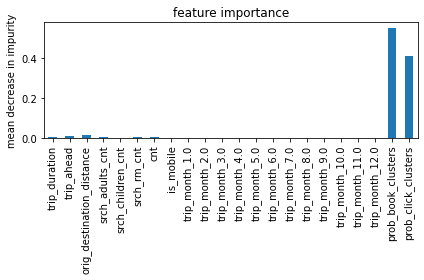

In [30]:
importances = pd.Series(clf.feature_importances_, index=feature2fit_X)

fig, ax = plt.subplots()
importances.plot.bar(ax=ax)
ax.set_title("feature importance")
ax.set_ylabel("mean decrease in impurity")
fig.tight_layout()

### [single ML Model]: 1 classifications with Logistic Regressor <a id='single_ml_model_logistic'></a>

In [14]:
df_train = pd.read_csv('data/train_booking.csv')
df_dev = pd.read_csv('data/dev_booking.csv')

In [15]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

scaler = MinMaxScaler()
vars_minmax = ['srch_adults_cnt','srch_children_cnt','srch_rm_cnt','cnt','trip_duration','trip_ahead','orig_destination_distance']

df_train_minmax = pd.DataFrame(scaler.fit_transform(df_train[vars_minmax]), columns=[vars_minmax])
df_dev_minmax = pd.DataFrame(scaler.fit_transform(df_dev[vars_minmax]), columns=[vars_minmax])

df_train.drop(columns=vars_minmax, axis=1)
df_dev.drop(columns=vars_minmax, axis=1)

df_train[vars_minmax] = df_train_minmax
df_dev[vars_minmax] = df_dev_minmax

In [16]:
def explode_is_booking(hotel_cluster):
    target = np.zeros(100, dtype=int)
    target[int(hotel_cluster)] = 1
    return target


df_train['is_booking'] = df_train.apply(lambda x: explode_is_booking(x['hotel_cluster']),axis=1)
df_dev['is_booking'] = df_dev.apply(lambda x: explode_is_booking(x['hotel_cluster']),axis=1)
df_train['cluster'] = df_train.apply(lambda x: np.arange(100),axis=1)
df_dev['cluster'] = df_dev.apply(lambda x: np.arange(100),axis=1)


predictors = ['trip_duration','trip_ahead','orig_destination_distance','srch_adults_cnt','srch_children_cnt','srch_rm_cnt','cnt',
              'srch_destination_id', 'cluster','is_booking']


df_train_model3 = pd.merge(df_train[predictors], df_2d[['srch_destination_id','prob_book_clusters','prob_click_clusters']], 
                           how='left', on=['srch_destination_id'])
df_dev_model3 = pd.merge(df_dev[predictors], df_2d[['srch_destination_id','prob_book_clusters','prob_click_clusters']], 
                         how='left', on=['srch_destination_id'])

In [17]:
df_dev_model3['prob_book_clusters'] = df_dev_model3['prob_book_clusters'].apply(lambda x: x if type(x) is not float else [0.]*100)
df_dev_model3['prob_click_clusters'] = df_dev_model3['prob_click_clusters'].apply(lambda x: x if type(x) is not float else [0.]*100)

#### Data aggregation: the 2D matching

In [18]:
df_train_model3_explode = df_train_model3.explode(['is_booking','cluster','prob_book_clusters','prob_click_clusters'])
df_dev_model3_explode = df_dev_model3.explode(['is_booking','cluster','prob_book_clusters','prob_click_clusters'])

df_train_model3_explode.reset_index(inplace=True)
df_dev_model3_explode.reset_index(inplace=True)

In [19]:
df_train_model3

,trip_duration,trip_ahead,orig_destination_distance,srch_adults_cnt,srch_children_cnt,srch_rm_cnt,cnt,srch_destination_id,cluster,is_booking,prob_book_clusters,prob_click_clusters
0,0.000000,0.042084,0.442644,0.111111,0.000000,0.125,0.0,12643,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0127, 0.0, 0.0, 0.019, 0.0, 0.006...","[0.0, 0.0, 0.0158, 0.0041, 0.0, 0.0397, 0.0, 0..."
1,0.000000,0.006012,0.131164,0.222222,0.000000,0.250,0.0,12007,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,0.016949,0.040080,0.143027,0.222222,0.000000,0.125,0.0,12233,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0304, 0.0063, 0.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.0342, 0.0063, 0.0, 0.0,..."
3,0.000000,0.164329,0.143027,0.222222,0.222222,0.125,0.0,8864,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.025...","[0.0, 0.0, 0.0, 0.0021, 0.0, 0.0, 0.0, 0.0, 0...."
4,0.033898,0.058116,0.143027,0.222222,0.000000,0.125,0.0,12250,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.216, 0.0, 0.0, 0.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.2279, 0.0, 0.0, 0...."
...,...,...,...,...,...,...,...,...,...,...,...,...
1024384,0.050847,0.515030,0.405780,0.222222,0.111111,0.125,0.0,8221,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0527, 0.0149, 0.0, 0.0017, 0.0, 0...","[0.0, 0.0, 0.0344, 0.0261, 0.0, 0.0009, 0.0001..."
1024385,0.000000,0.004008,0.075365,0.222222,0.000000,0.125,0.0,8272,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0429, 0.0, 0.0163, 0.0019, 0.0011, 0.0072, ...","[0.0534, 0.0, 0.0129, 0.0014, 0.0006, 0.0096, ..."
1024386,0.118644,0.286573,0.143027,0.222222,0.000000,0.125,0.0,8267,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0097, 0.0116, 0.006, 0.0004,...","[0.0, 0.0, 0.0, 0.0104, 0.0134, 0.0075, 0.0006..."
1024387,0.016949,0.078156,0.143027,0.222222,0.000000,0.125,0.0,12183,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...","[0.1853, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....","[0.1994, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...."


In [21]:
feature2fit_X = ['trip_duration','trip_ahead','orig_destination_distance','srch_adults_cnt','srch_children_cnt','srch_rm_cnt','cnt', 
                 'prob_book_clusters','prob_click_clusters']

In [22]:
clf = LogisticRegression(max_iter=350, n_jobs=-1, random_state=0)
clf.fit(df_train_model3_explode[feature2fit_X], df_train_model3_explode['is_booking'].astype('int'))   
prob = clf.predict_proba(df_dev_model3_explode[feature2fit_X])[:, 1]

In [23]:
from joblib import dump, load
dump(clf, 'data/model3.joblib')

['data/model3.joblib']

In [26]:
print(clf.coef_[0])

[ 0.25110411  0.0357535   0.11936018 -0.08098062  0.36172528 -0.02687929
 -0.6056202   9.99251847  8.61435609]


In [27]:
prob_table = pd.DataFrame({
    'index': df_dev_model3_explode['index'],
    'cluster':df_dev_model3_explode['cluster'],
    'pred':prob
})
prob_table

,index,cluster,pred
0,0,0,0.005674
1,0,1,0.005674
2,0,2,0.006717
3,0,3,0.005787
4,0,4,0.011766
...,...,...,...
197630395,1976303,95,0.005559
197630396,1976303,96,0.010031
197630397,1976303,97,0.005559
197630398,1976303,98,0.005559


In [28]:
prob_table_pivot = prob_table.pivot(index='index', columns='cluster', values='pred')
prob_table_pivot.to_csv('data/model3/prob_table_pivot.csv', index=False)
prob_table_pivot

cluster,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
index,,,,,,,,,,,,,,,,,,,,,
0,0.005674,0.005674,0.006717,0.005787,0.011766,0.006765,0.009002,0.005949,0.005674,0.008686,...,0.005761,0.009571,0.005674,0.005762,0.006284,0.011083,0.006092,0.011792,0.016155,0.006682
1,0.005958,0.005958,0.005958,0.005958,0.005958,0.005958,0.005958,0.026902,0.005958,0.005958,...,0.005958,0.043586,0.005958,0.005958,0.027502,0.005958,0.005958,0.005958,0.005958,0.005958
2,0.005521,0.396291,0.005458,0.005458,0.005458,0.005458,0.005458,0.005458,0.005458,0.005458,...,0.005822,0.006738,0.005597,0.005458,0.005997,0.005458,0.005732,0.005458,0.005458,0.005458
3,0.005824,0.005824,0.005824,0.005824,0.005824,0.005824,0.041313,0.005824,0.005824,0.005854,...,0.005824,0.005824,0.005824,0.005824,0.005824,0.005824,0.005824,0.005824,0.005824,0.005824
4,0.005555,0.005555,0.005555,0.005555,0.005555,0.021364,0.005555,0.005555,0.005555,0.005555,...,0.219741,0.008186,0.005555,0.019866,0.008953,0.005555,0.005555,0.005555,0.005555,0.005555
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1976299,0.005556,0.005556,0.005556,0.005556,0.005556,0.005556,0.005556,0.005556,0.005556,0.005556,...,0.005556,0.005556,0.005556,0.005556,0.005556,0.005556,0.005556,0.005556,0.005556,0.005556
1976300,0.005526,0.005526,0.005526,0.009248,0.005526,0.005526,0.005526,0.005526,0.006284,0.005526,...,0.080523,0.005526,0.005526,0.007624,0.005526,0.005526,0.005526,0.005526,0.005526,0.005526
1976301,0.005543,0.005543,0.005543,0.005543,0.005543,0.009056,0.132534,0.005543,0.005543,0.005543,...,0.005543,0.039176,0.005543,0.005543,0.009338,0.013681,0.005543,0.005543,0.005543,0.005543


In [30]:
pred_table = pd.DataFrame(
                prob_table_pivot.apply(lambda x: list(prob_table_pivot.columns[np.array(x).argsort()[::-1][:5]]), axis=1).to_list(),  
                columns=['pred_1','pred_2','pred_3','pred_4','pred_5'])
pred_table['ans'] = df_dev['hotel_cluster']
pred_table

,pred_1,pred_2,pred_3,pred_4,pred_5,ans
0,98,97,4,21,41,17
1,91,28,47,42,94,91
2,1,45,79,24,88,54
3,46,15,6,81,62,36
4,73,90,72,48,5,90
...,...,...,...,...,...,...
1976299,99,36,26,27,28,7
1976300,81,62,90,30,44,20
1976301,6,91,42,18,77,51
1976302,91,18,16,89,94,91


In [33]:
actual = [[ele] for ele in pred_table['ans'].tolist()]
predicted = [row[:5] for row in pred_table.values.tolist()]

mapk(actual, predicted, k=5)

0.3062068217575164

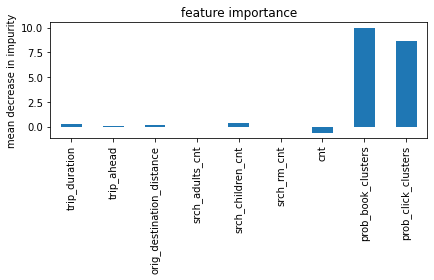

In [35]:
importances = pd.Series(data=clf.coef_[0], index=feature2fit_X)

fig, ax = plt.subplots()
importances.plot.bar(ax=ax)
ax.set_title("feature importance")
ax.set_ylabel("mean decrease in impurity")
fig.tight_layout()

#### Probability Sum:<a id='probability_sum'></a> point-wise approach

* Fig. 1: probability sum of the top 5 possibilities. \
Those recommendations that hit the target have a slightly higher probability sum, but not really a big difference between the recommendations users didn't pick any. 

* Fig. 2: the fraction of the top 5 probability sum over all of the 100 prediction sum. \
Now we finally can see some differences between the user-picked and user-non-picked. For those recommendations that don't predict the user's preferences, they have overall a low predicting probability. Although we selected the top 5 possibilities, their probability is not much higher than that of other options, so we can observe the 20% peak value on the left.

* Fig. 3: for the next set of 5 recommendations, what percentage of the top 5 improved in terms of the probability? \
It further confirms what we already seen in the previous plot. Only the recommendations with correct predictions have a significantly higher probabilities than other options, so we can see the blue peak above the 80% improvement. 

In [128]:
s = prob_table_pivot.apply(lambda x: x.nlargest(10).values, axis=1)

prob_table_summary = pd.DataFrame({
    'prob_5sum': [p[:5].sum() for p in s],
    'prob_next5sum': [p[-5:].sum() for p in s],
    'is_correct': pred_table.apply(lambda x: any([x['ans']==x['pred_'+str(i)] for i in range(1,6)]), axis=1) })

prob_table_summary['diff_frac'] = (prob_table_summary['prob_5sum'] - prob_table_summary['prob_next5sum'])/prob_table_summary['prob_5sum']
prob_table_summary['top5_frac'] = prob_table_summary['prob_5sum']/prob_table_pivot.apply(lambda x: x.sum(), axis=1)
prob_table_summary

,prob_5sum,prob_next5sum,is_correct,diff_frac,top5_frac
0,0.062741,0.053128,False,0.153210,0.089015
1,0.179953,0.096978,True,0.461095,0.213293
2,0.585425,0.060745,False,0.896238,0.510114
3,0.325991,0.092906,False,0.715004,0.342307
4,0.899844,0.067751,True,0.924708,0.612852
...,...,...,...,...,...
1976299,0.027778,0.027778,False,0.000000,0.050000
1976300,0.910971,0.045657,False,0.949881,0.620465
1976301,0.254903,0.068429,False,0.731550,0.300199
1976302,1.476605,0.042819,True,0.971002,0.729900


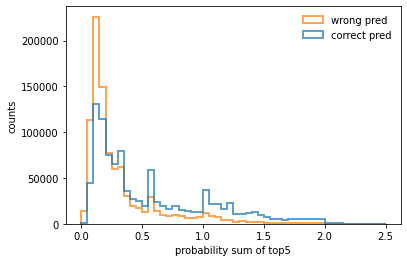

In [119]:
fig, ax = plt.subplots()
ax.hist([prob_table_summary[prob_table_summary['is_correct']==True]['prob_5sum'], prob_table_summary[prob_table_summary['is_correct']==False]['prob_5sum']], 
        bins=50, range=[0,2.5], histtype='step', linewidth=2, alpha=0.7,
        label=['correct pred','wrong pred'])
ax.legend(frameon=False)
plt.ylabel('counts')
plt.xlabel('probability sum of top5')
plt.show()

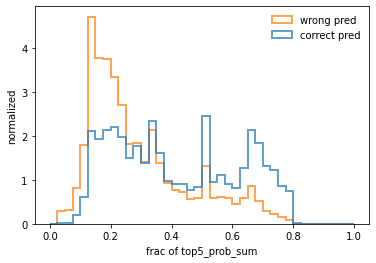

In [150]:
fig, ax = plt.subplots()
ax.hist([prob_table_summary[prob_table_summary['is_correct']==True]['top5_frac'], prob_table_summary[prob_table_summary['is_correct']==False]['top5_frac']], 
        bins=40, range=[0,1], histtype='step', linewidth=2, alpha=0.7, density=1, 
        label=['correct pred','wrong pred'])
ax.legend(frameon=False)
plt.ylabel('normalized')
plt.xlabel('frac of top5_prob_sum')
plt.show()

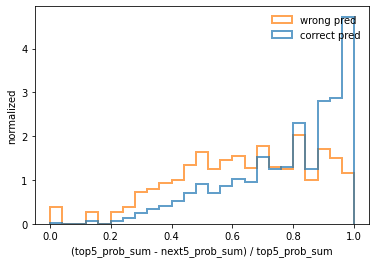

In [151]:
fig, ax = plt.subplots()
ax.hist([prob_table_summary[prob_table_summary['is_correct']==True]['diff_frac'], prob_table_summary[prob_table_summary['is_correct']==False]['diff_frac']], 
        bins=25, range=[0,1], histtype='step', linewidth=2, alpha=0.7, density=1, 
        label=['correct pred','wrong pred'])
ax.legend(frameon=False)
plt.ylabel('normalized')
plt.xlabel('(top5_prob_sum - next5_prob_sum) / top5_prob_sum')
plt.show()

### What can do for next steps:<a id='for_next'></a>

##### **[Feature Engineering]:**
There are also some features that can be explored and tried, which will play a certain role in improving the predicting performance. Such as which continent the hotel is in, or whether the travel plan is in summer months or on weekends, etc. 

As indicated in the studies above, matching the *srch_destination_id* to the most frequently booked or clicked hotels really plays the key of predictions, therefore, it should be helpful to make more use of the features regarding to *srch_destination_id*. We haven't used any information in the file *destination.csv* that includes 149 latent spaces. Exploring it with some features to build our model should be the priorities on the list of the next tasks.

##### **[Cross Validation Sampling]:**
At present, this analysis is based on the model built in *2013* data, expecting that it can have a good level of performance on predicting the booking in *2014* data. There are many other different sampling approaches, for example, one way is to make *2013 + the first half of 2014* data as the training set and *the second half of 2014* data as the test set. In another very different way, we can also look for a smaller division instead of a large range of time spans. For example, a model can be built on a month and use it to predict the results of the next month. For how many months of data are available, there can be the same amounts of models build. We can see if the evaluation metric changes over the months. 

The advantage of this sampling is that we usually expect that the user's behavior won't change much in such short terms and the data will not be stale, while the cons is that the amount of data used to train the models are smaller. Although this approach reduces the possible biases, it also introduces variances. When we consider how to sample our data, we should always consider the trade-off between bias and variance.